# Imports

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import pickle

# Functions

In [3]:
def get_experiment_directory_str(base_name : str, maxk : int, benchmark : str, spec : str, stochastic : bool = True):
    return f"{base_name}/train_{'stochastic' if stochastic else 'deterministic'}/maxk={maxk}/{benchmark}-{spec}"

In [4]:
def moving_average(array, length):
    return np.convolve(array, np.ones(length), 'same') / length

In [5]:
import scipy.stats
def compute_confidence_interval(array, axis=None, percent=0.95):
    return scipy.stats.t.interval(alpha=percent, df=len(array)-1,
              loc=np.mean(array, axis=axis),
              scale=scipy.stats.sem(array, axis=axis))

In [6]:
def get_traces(base_exp_name, metric = "robust_value", num_runs = 30):
    traces = []
    for i in range(num_runs):
        if metric.lower() in {"static_values", "a_loss", "r_loss"}:
            with open(f"{base_exp_name}/0/{i}/{metric}.txt", 'r') as input:
                trace = np.array([np.array([float(x) for x in line.rstrip()[1:][:-1].split(" ") if x != ""], dtype=float) for line in input if line != ""], dtype=float)
        else:
            with open(f"{base_exp_name}/0/{i}/{metric}.txt", 'r') as input:
                trace = np.array([float(line.rstrip()) for line in input], dtype=float)
        traces.append(trace)
    return np.array(traces)

In [7]:
benchmarks = ["SC-maze5", "intercept", "evade", "avoid"]

In [8]:
AAAI = "./data/output/AAAI-RUN-14-08-2023_16h"

# Plotting functions

In [7]:
def rnn_empir_plot(basename, maxk, name):
    for run in ["Rminmax", "Rminmin", "Rminmax-BASELINE"]:
        results = get_traces(get_experiment_directory_str(basename, maxk, name, run), metric="rnn_empirical_result")
        # plt.plot(range(100), np.transpose(results))
        plt.plot(range(100), results.mean(axis=0), label=run)
        plt.fill_between(range(100), results.mean(axis=0) + results.std(axis=0), results.mean(axis=0) - results.std(axis=0), alpha=0.75)
        plt.title(f"{name}, $k\leq {maxk}$")
        plt.ylabel("RNN empirical result")
        plt.xlabel("Iteration")
    plt.legend()
    plt.show()

In [23]:
def losses_plot(basename, maxk, name):
    for run in ["Rminmax", "Rminmin", "Rminmax-BASELINE"]:
        for loss in ['a_loss', 'r_loss']:
            results = get_traces(get_experiment_directory_str(basename, maxk, name, run), metric=loss).mean(axis=-1)
        # plt.plot(range(100), np.transpose(results))
            plt.plot(range(100), results.mean(axis=0), label=f"{run}_{loss}")
            plt.fill_between(range(100), results.mean(axis=0) + results.std(axis=0), results.mean(axis=0) - results.std(axis=0), alpha=0.75)
        plt.title(f"{name}, $k\leq {maxk}$")
        plt.ylabel("Losses")
        plt.xlabel("Iteration")
    plt.legend()
    plt.show()

In [8]:
def make_rnn_learning_empir_plot(basename, name):
    for run in ["Rminmax", "Rminmin", "Rminmax-BASELINE"]:
        for maxk in [3, 9]:
            results = np.concatenate([get_traces(get_experiment_directory_str(basename, 3, name, run), metric="rnn_empirical_result")[..., np.newaxis],
                                      get_traces(get_experiment_directory_str(basename, 9, name, run), metric="rnn_empirical_result")[..., np.newaxis]], axis=-1).mean(axis=-1)
        plt.plot(range(100), results.mean(axis=0), label="Baseline" if "BASELINE" in run else run)
        plt.fill_between(range(100), results.mean(axis=0) + results.std(axis=0), results.mean(axis=0) - results.std(axis=0), alpha=0.75)
        # plt.title(f"{name}")
        print(name, ":")
        plt.ylabel("RNN empirical result")
        plt.xlabel("Iteration")
    plt.legend()
    # plt.savefig(f"empirical-learning-{name}.pgf", backend='pgf', format='pgf', bbox_inches = 'tight', pad_inches = 0)
    plt.savefig(f"empirical-learning-{name}.pdf", backend='pdf', format='pdf', bbox_inches = 'tight', pad_inches = 0)
    plt.show()

SC-maze5 :
SC-maze5 :
SC-maze5 :


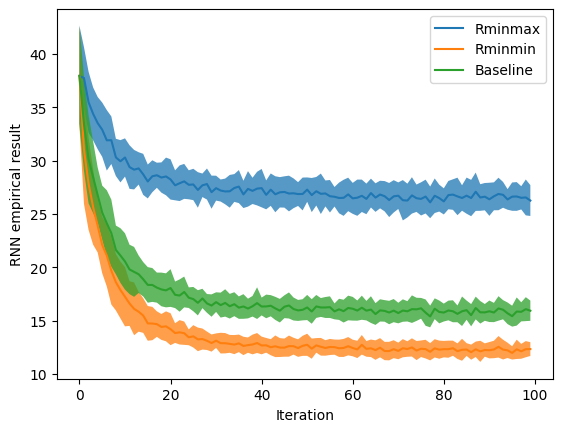

intercept :
intercept :
intercept :


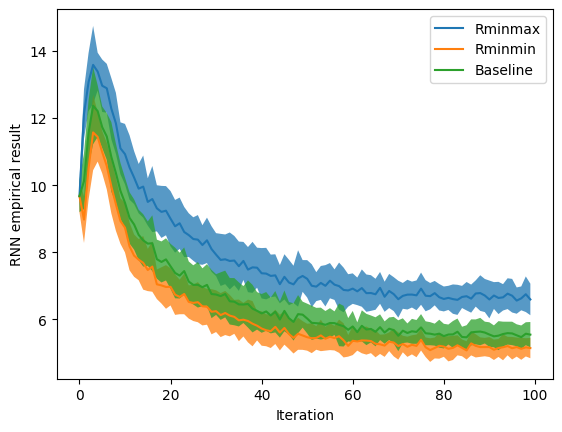

evade :
evade :
evade :


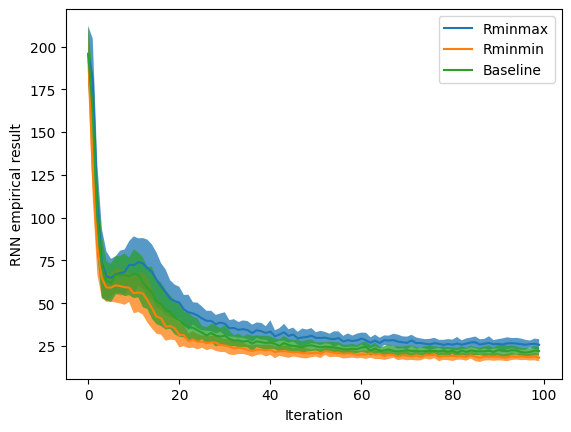

In [82]:
for benchmark in benchmarks[:3]:
    make_rnn_learning_empir_plot("./data/output/AAAI-RUN-14-08-2023_16h", benchmark)

In [ ]:
results = np.reshape(get_traces(get_experiment_directory_str("./data/output/AAAI-RUN-14-08-2023_16h", 3, "SC-maze5", "Rminmax"), metric="static_values"), (30, 4, 100))

In [9]:
results = np.reshape(get_traces(get_experiment_directory_str("./data/output/AAAI-RUN-14-08-2023_16h", 3, "SC-maze5", "Rminmax"), metric="static_values"), (30, 4, 100))

In [9]:
def static_evals_subplots(basepath, maxk, name, confidence_interval=False):
    plt.figure(figsize=(12,9))
    plt.suptitle("SC-Maze-5, $k\leq {maxk}$")
    for run in ["Rminmax", "Rminmin", "Rminmax-BASELINE"]:
        results = np.reshape(get_traces(get_experiment_directory_str(basepath, maxk, name, run), metric="static_values"), (30, 4, 100))
        values = [0.1, 0.2, 0.3, 0.4]
        for i in range(4):
            plt.subplot(2, 2, i+1)
            # plt.plot(range(100), np.transpose(results[:, i, :]), label=run)
            plt.plot(range(100), np.mean(results[:, i, :], axis=0), label=run)
            # plt.fill_between(range(100), results[:, i, :].mean(axis=0) + results[:, i, :].std(axis=0), results[:, i, :].mean(axis=0) - results[:, i, :].std(axis=0), alpha=0.75)
            if confidence_interval:
                y1, y2 = confidence_interval(results[:, i, :], axis=0)
                plt.fill_between(range(100), y1, y2, alpha=.75)
            plt.title(f"sl = {values[i]}")
            plt.ylabel("Value")
            # plt.yscale("log")
            plt.xlabel("Iteration")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [10]:
def max_static_value_plot(basepath, maxk, name, moving_average_length = None, confidence_interval = False):
    plt.figure(figsize=(12,9))
    plt.title(f"{name}, $k\leq {maxk}$")
    for run in ["Rminmax", "Rminmin", "Rminmax-BASELINE"]:
        results = np.reshape(get_traces(get_experiment_directory_str(basepath, maxk, name, run), metric="static_values"), (30, 4, 100))
        plt.plot(range(100), moving_average(np.mean(np.max(results, axis=1), axis=0), moving_average_length) if moving_average_length else np.mean(np.max(results, axis=1), axis=0), label=run)
        # plt.fill_between(range(100), results[:, i, :].mean(axis=0) + results[:, i, :].std(axis=0), results[:, i, :].mean(axis=0) - results[:, i, :].std(axis=0), alpha=0.75)
        if confidence_interval:
            y1, y2 = compute_confidence_interval(np.max(results, axis=1), axis=0, percent=0.9)
            plt.fill_between(range(100), y1, y2, alpha=.75)
    plt.ylabel("Value")
    plt.xlabel("Iteration")
    plt.legend()
    plt.tight_layout()
    plt.show()

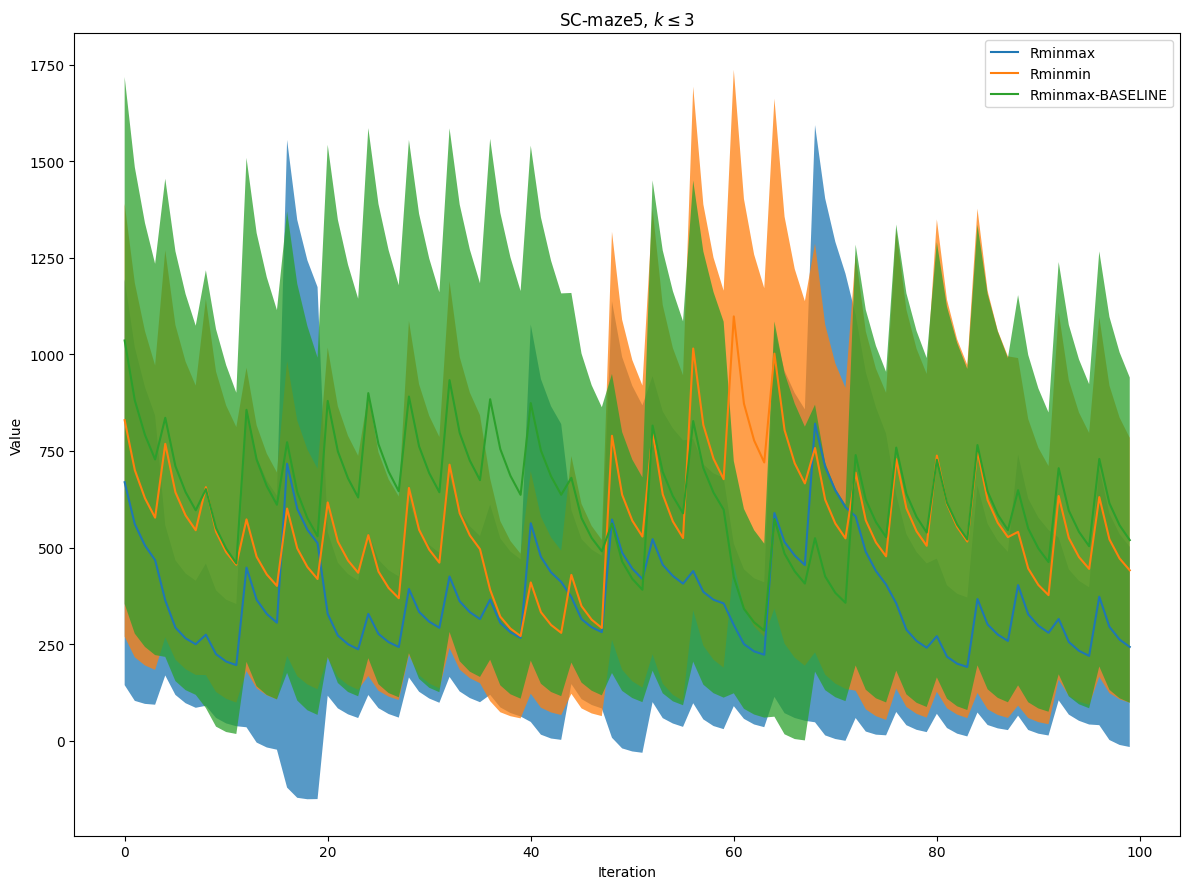

In [13]:
max_static_value_plot("./data/output/AAAI-RUN-14-08-2023_16h", 3, "SC-maze5", confidence_interval=True)

In [11]:
def make_robust_plot(basepath, maxk, name, moving_average_length = None):
    for run in ["Rminmax", "Rminmin", "Rminmax-BASELINE"]:
        results = get_traces(get_experiment_directory_str(basepath, maxk, name, run), metric="robust_value")
        # plt.plot(range(100), np.transpose(results))
        plt.plot(range(100), moving_average(results.mean(axis=0), moving_average_length) if moving_average_length else results.mean(axis=0), label=run)
        # plt.fill_between(range(100), results.mean(axis=0) + results.std(axis=0), results.mean(axis=0) - results.std(axis=0), alpha=0.75)
        plt.title(f"{name}, $k\leq {maxk}$")
        plt.ylabel("Robust value")
        # plt.yscale("log")
        plt.xlabel("Iteration")
    plt.legend()
    plt.show()

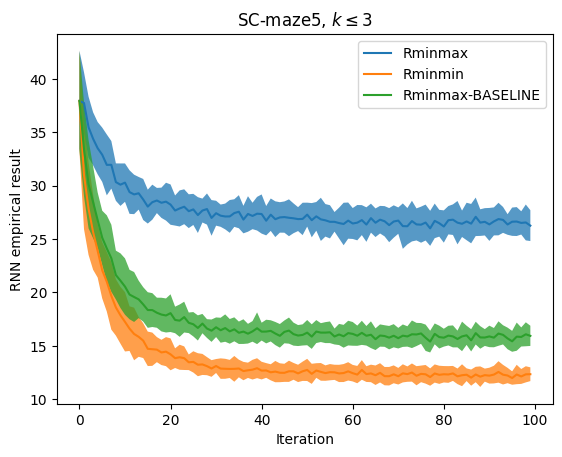

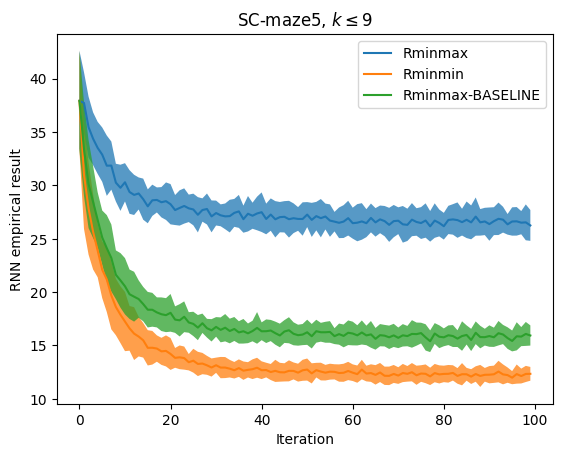

In [19]:
rnn_empir_plot("./data/output/AAAI-RUN-14-08-2023_16h", 3, "SC-maze5")
rnn_empir_plot("./data/output/AAAI-RUN-14-08-2023_16h", 9, "SC-maze5")

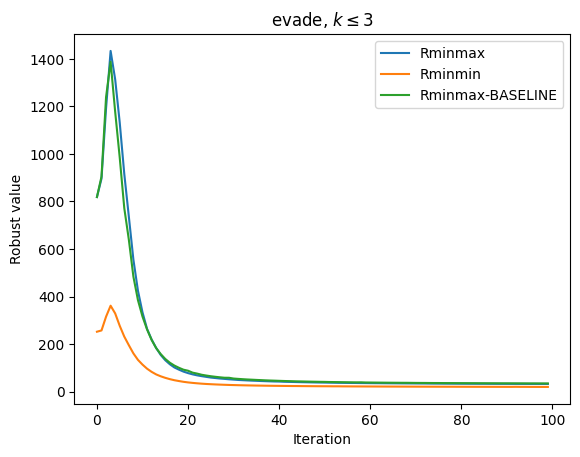

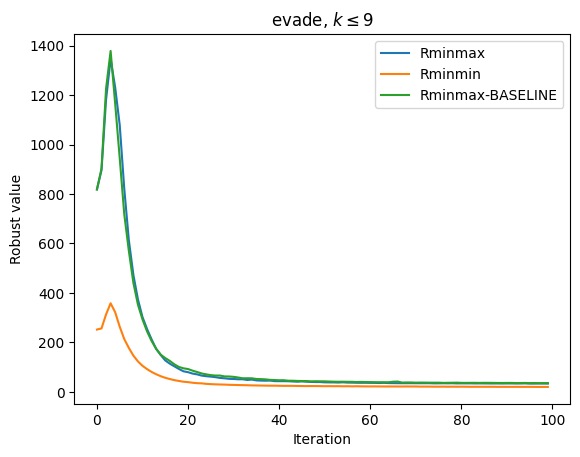

In [25]:
make_robust_plot("./data/output/AAAI-RUN-14-08-2023_16h", 3, "evade")
make_robust_plot("./data/output/AAAI-RUN-14-08-2023_16h", 9, "evade")

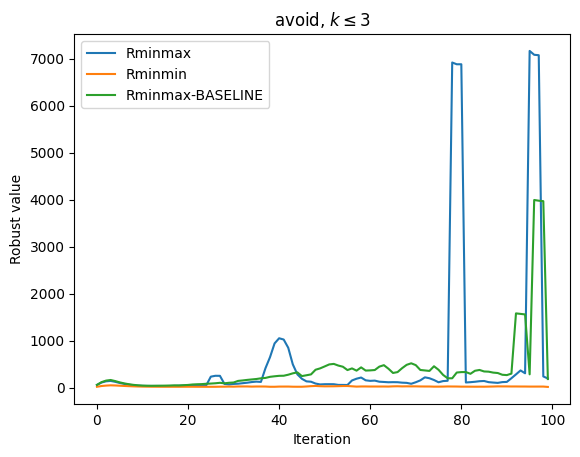

In [27]:
make_robust_plot("./data/output/AAAI-RUN-14-08-2023_16h", 3, "avoid", moving_average_length=3)

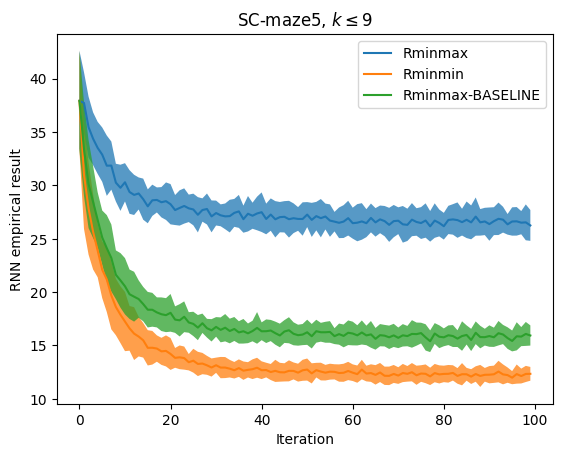

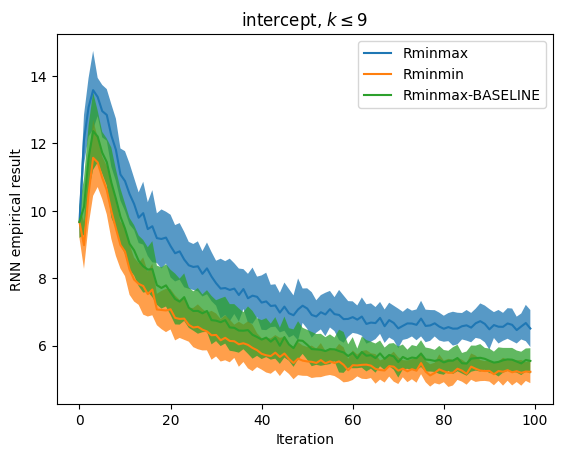

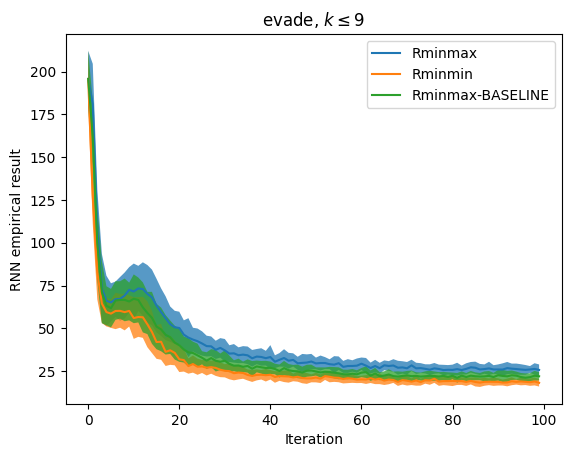

/tmp/ipykernel_1634782/2755108051.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(traces)


ValueError: operands could not be broadcast together with shapes (5,) (6,) 

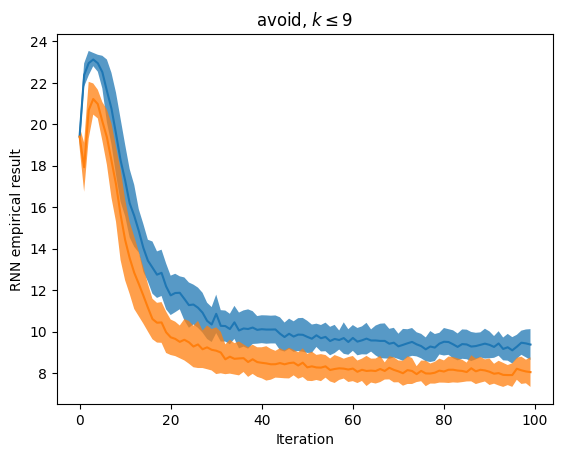

In [17]:
for benchmark in benchmarks:
    rnn_empir_plot("./data/output/AAAI-RUN-14-08-2023_16h", 9, benchmark)

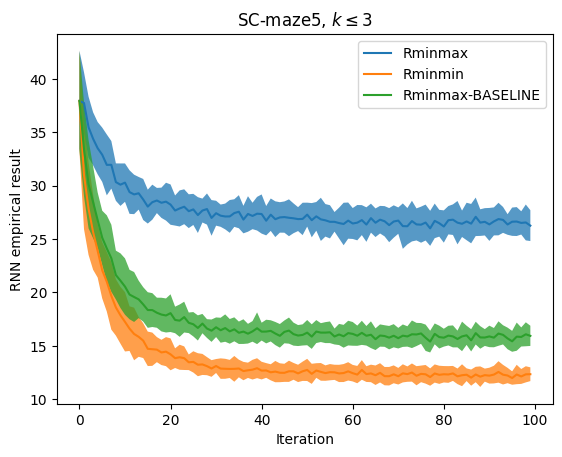

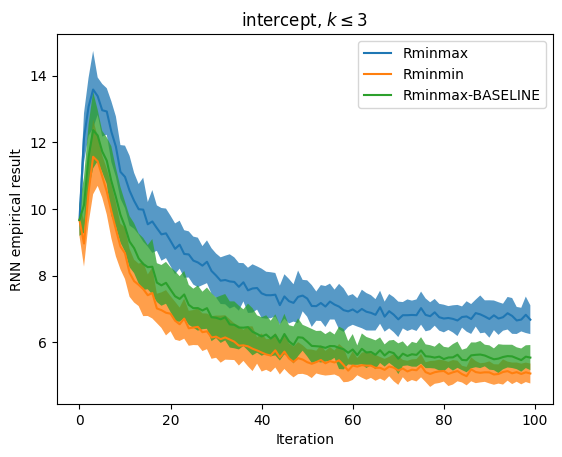

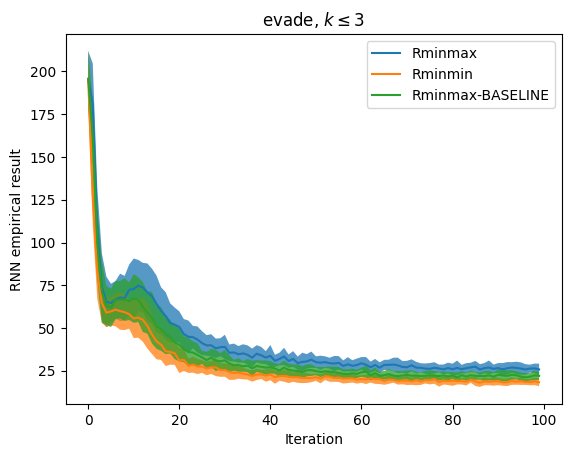

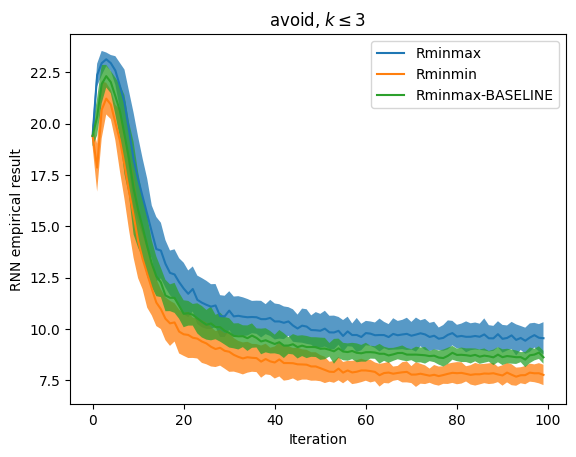

In [ ]:
for benchmark in benchmarks:
    rnn_empir_plot("./data/output/AAAI-RUN-14-08-2023_16h", 3, benchmark)

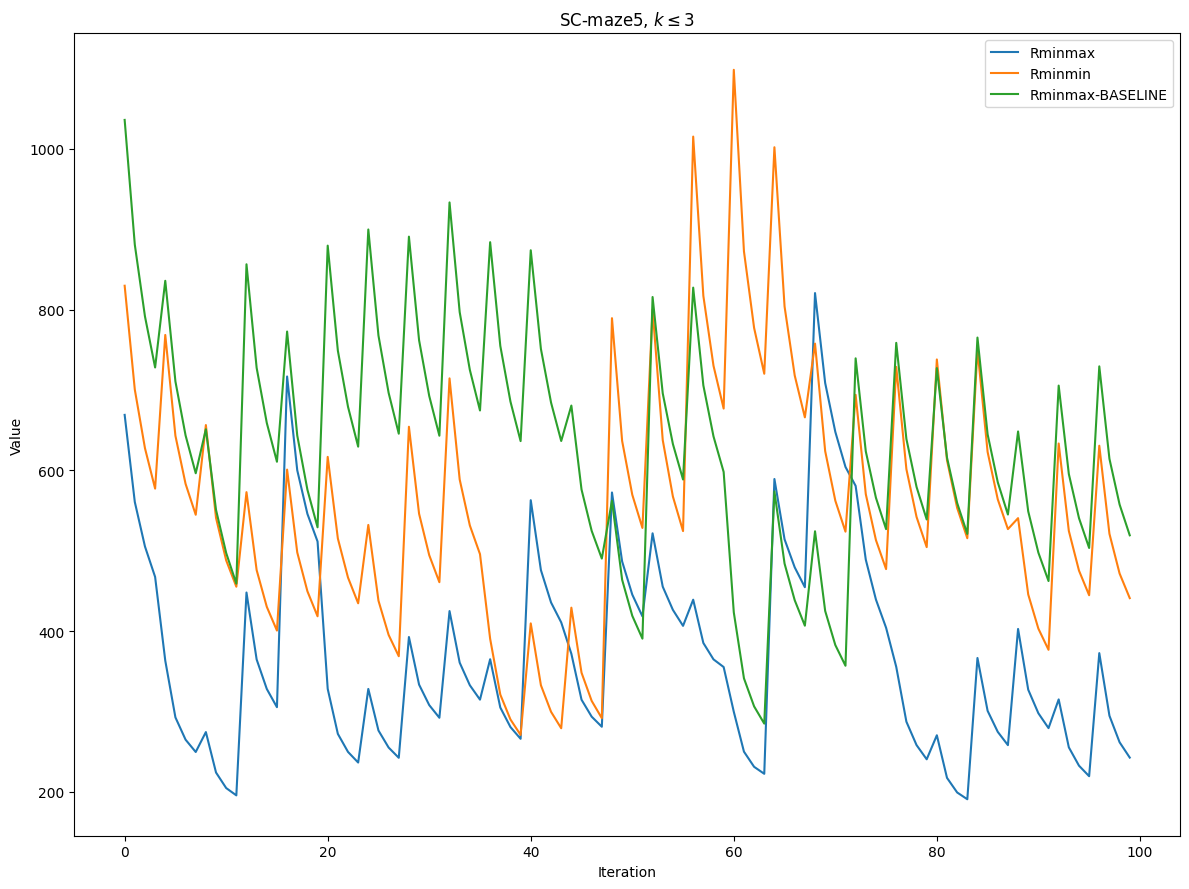

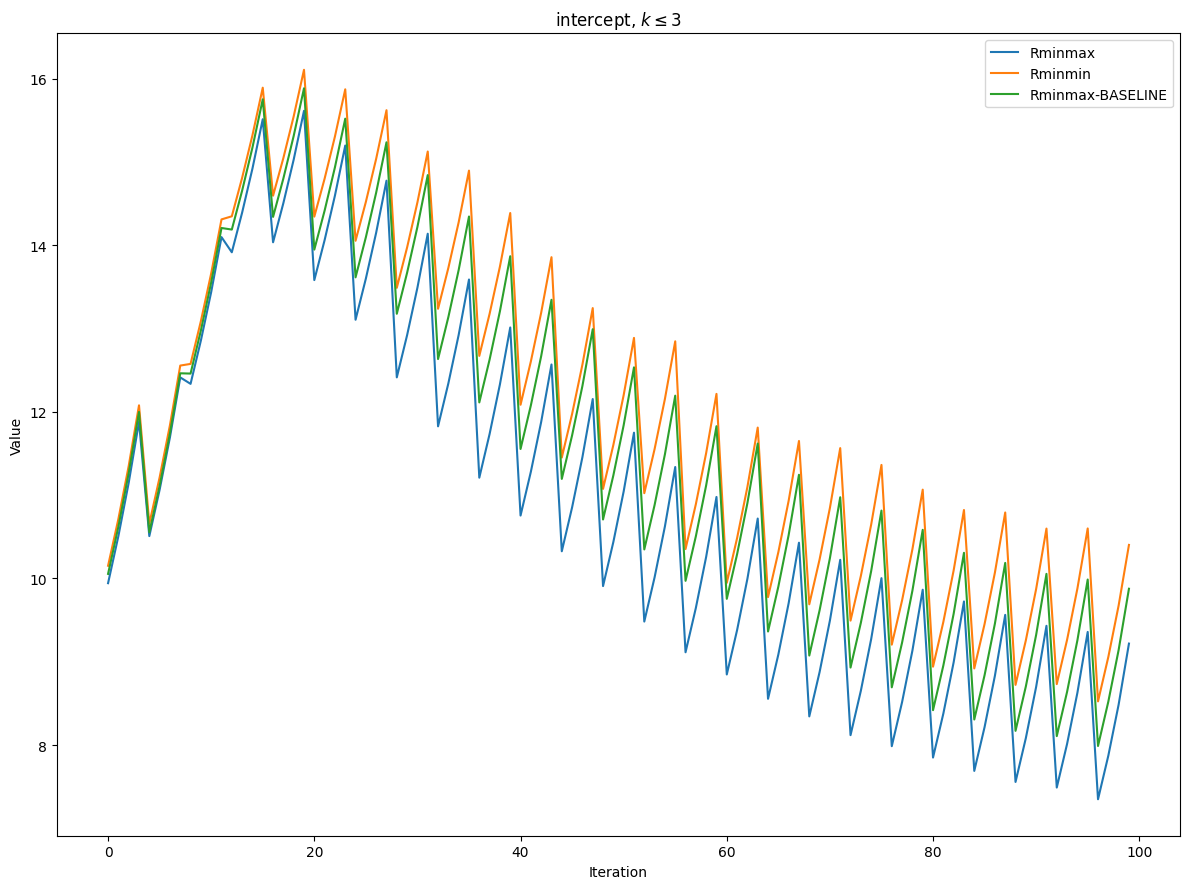

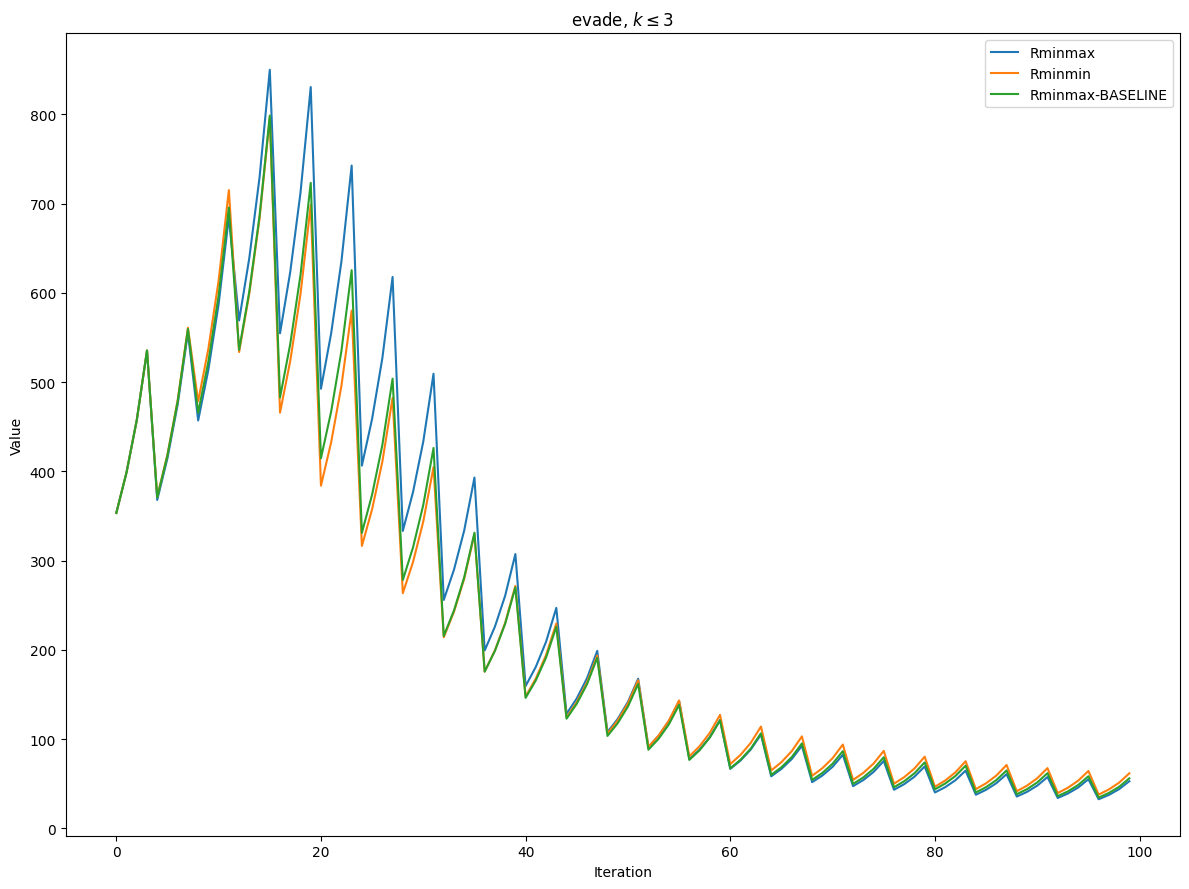

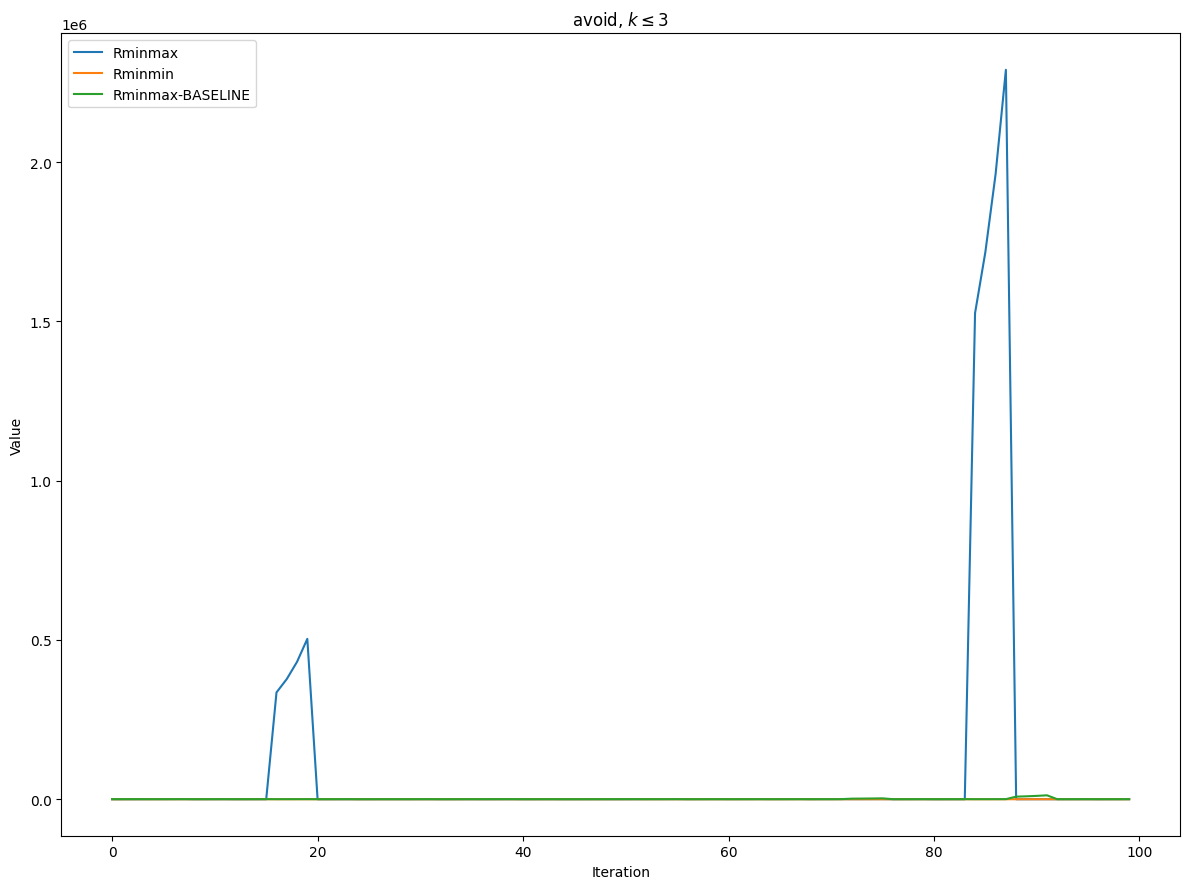

In [ ]:
for benchmark in benchmarks:
    max_static_value_plot("./data/output/AAAI-RUN-14-08-2023_16h", 3, benchmark, moving_average_length=None, confidence_interval=False)

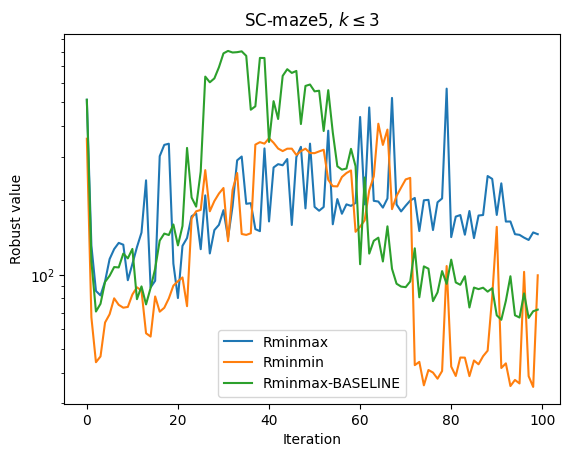

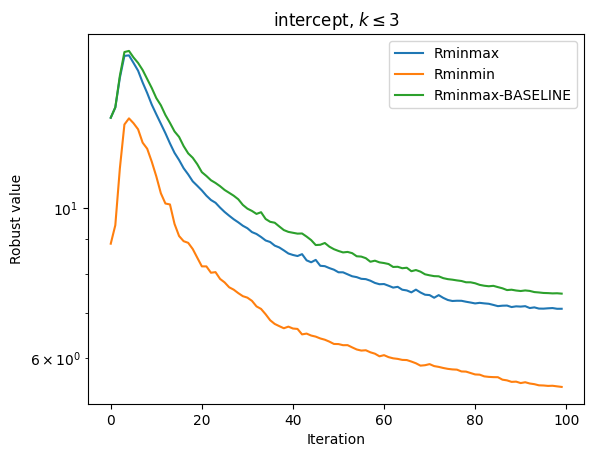

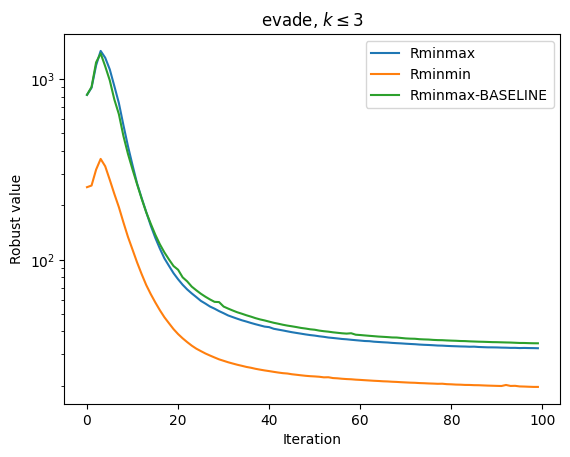

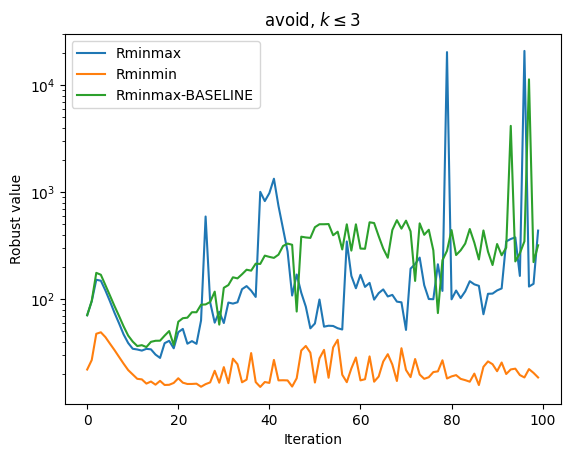

In [ ]:
for benchmark in benchmarks:
    make_robust_plot("./data/output/AAAI-RUN-14-08-2023_16h", 3, benchmark)

In [ ]:
# np.set_printoptions()

In [ ]:
results = get_traces(get_experiment_directory_str("./data/output/AAAI-RUN-14-08-2023_16h", 3, 'avoid', "Rminmax-BASELINE"), 'robust_value')

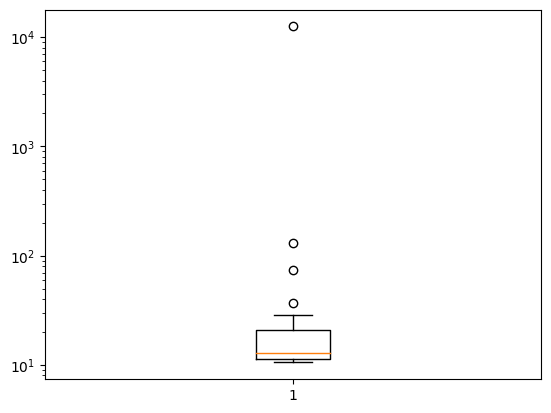

In [ ]:
plt.boxplot(results[:, -1])
plt.yscale('log')
plt.show()

In [ ]:
results[:, :-10].mean(axis=0).mean()

244.16496329798372

In [ ]:
results = get_traces(get_experiment_directory_str("./data/output/AAAI-RUN-14-08-2023_16h", 3, 'avoid', "Rminmax"), 'robust_value')

In [ ]:
results[:, :-10].mean(axis=0).mean()

383.6923060833433

In [ ]:
results[:, -10:].shape

(30, 10)

In [62]:
ylim = {
    'SC-maze5' : [20, 150],
    'intercept' : [5, 15],
    'evade' : [30, 40],
    'avoid' : [0, 250]
}

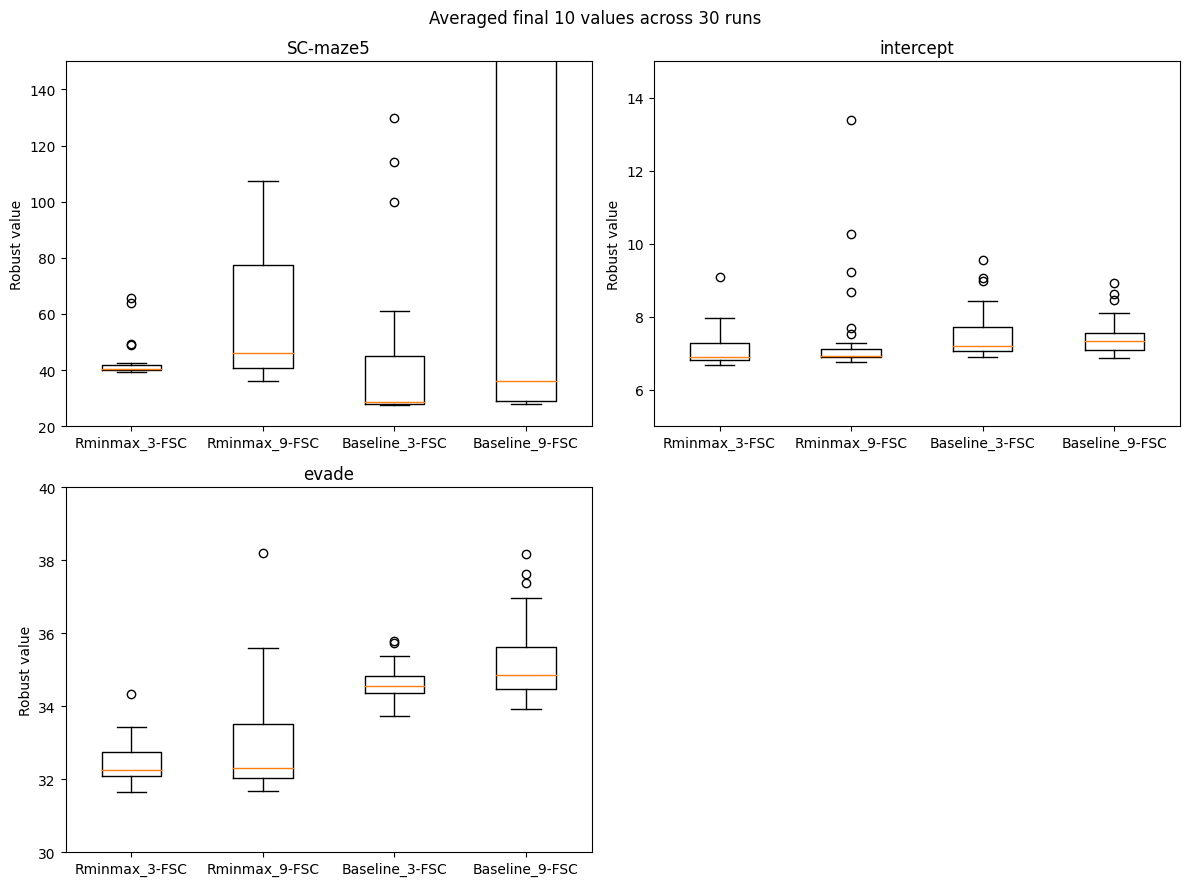

In [63]:
plt.figure(figsize=(12,9))
for i, benchmark in enumerate(benchmarks[:3]):
    plt.subplot(2, 2, i+1)
    lists = []
    for method in ['Rminmax', 'Rminmax-BASELINE']:    
        # values = []
        for k in [3, 9]:
            results = get_traces(get_experiment_directory_str("./data/output/AAAI-RUN-14-08-2023_16h", k, benchmark, method), 'robust_value')
            lists.append(results[:, -10:].mean(axis=-1))
    plt.title(benchmark)
    plt.boxplot(lists, labels=[f'Rminmax_3-FSC', f'Rminmax_9-FSC', f'Baseline_3-FSC', f'Baseline_9-FSC'])
    plt.ylabel("Robust value")
    plt.ylim(ylim[benchmark])
    # if np.array(lists).max() > 1e3: 
        # plt.yscale("log")
plt.suptitle("Averaged final 10 values across 30 runs")
plt.tight_layout()
plt.show()

In [58]:
ylim = {
    'SC-maze5' : [20, 80],
    'intercept' : [5, 10],
    'evade' : [30, 40],
    'avoid' : [0, 250]
}

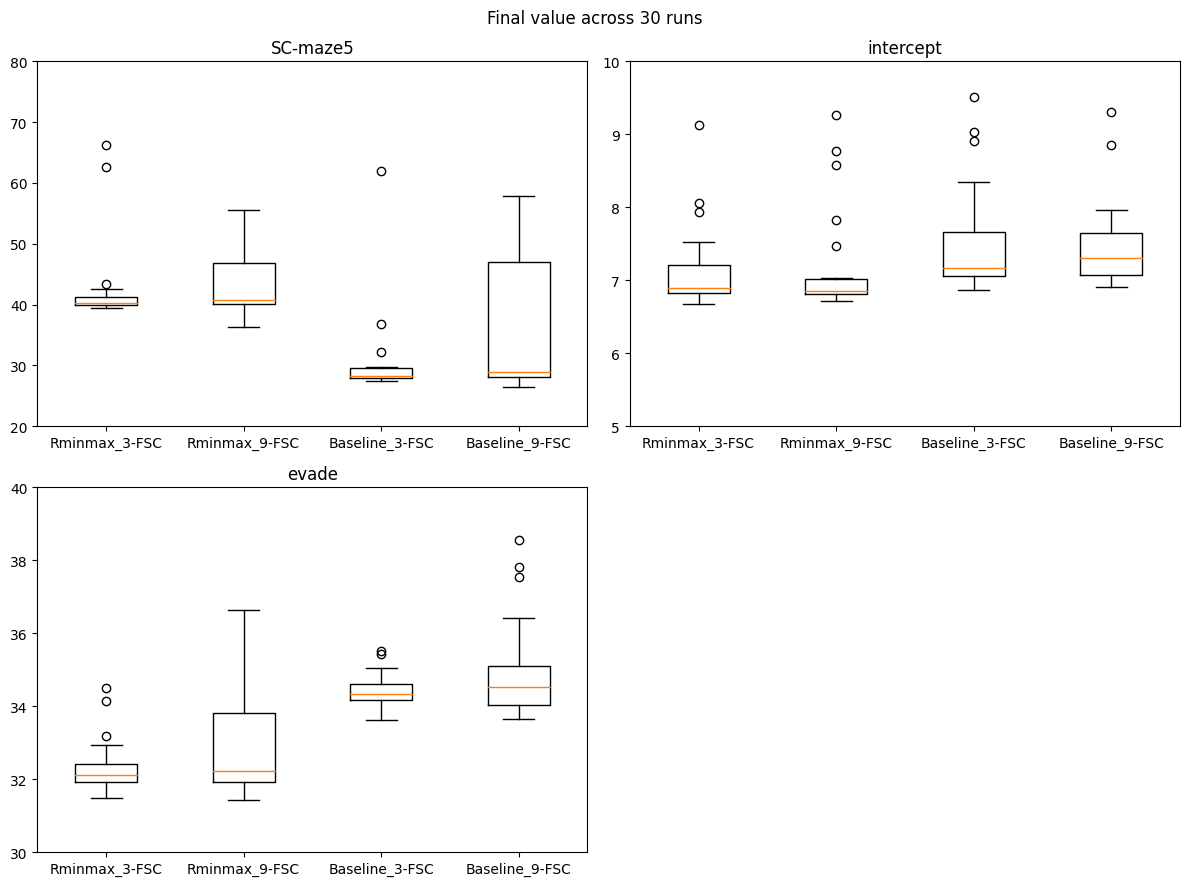

In [59]:
plt.figure(figsize=(12,9))
for i, benchmark in enumerate(benchmarks[:3]):
    plt.subplot(2, 2, i+1)
    lists = []
    for method in ['Rminmax', 'Rminmax-BASELINE']:    
        # values = []
        for k in [3, 9]:
            results = get_traces(get_experiment_directory_str("./data/output/AAAI-RUN-14-08-2023_16h", k, benchmark, method), 'robust_value')
            # lists.append(results[:, -10:].mean(axis=-1))
            lists.append(results[:, -1])
    plt.title(benchmark)
    plt.boxplot(lists, labels=[f'Rminmax_3-FSC', f'Rminmax_9-FSC', f'Baseline_3-FSC', f'Baseline_9-FSC'])
    # if np.array(lists).max() > 1e3:
        # plt.yscale("log")
    plt.ylim(ylim[benchmark])
plt.suptitle("Final value across 30 runs")
plt.tight_layout()
plt.show()

In [60]:
ylim = {
    'SC-maze5' : [20, 50],
    'intercept' : [5, 10],
    'evade' : [30, 40],
    'avoid' : [0, 250]
}

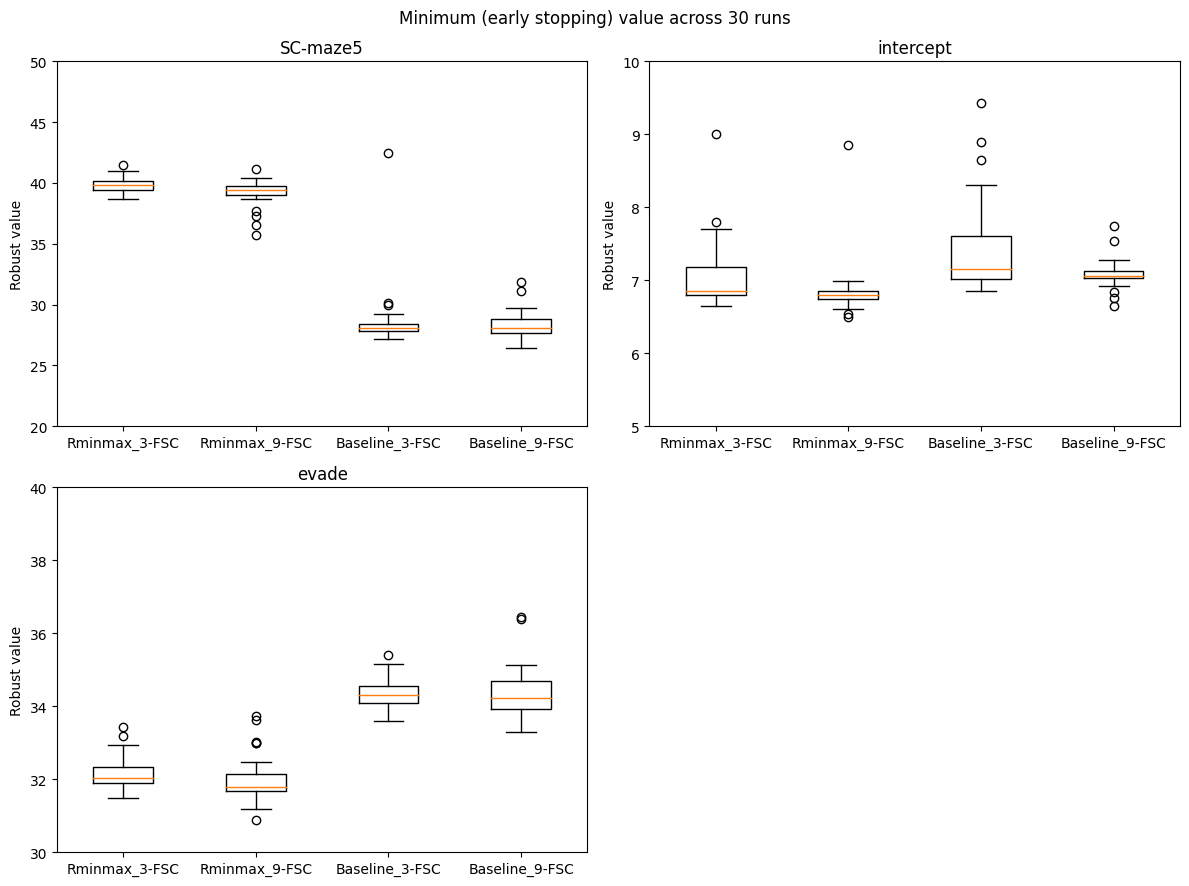

In [61]:
plt.figure(figsize=(12,9))
for i, benchmark in enumerate(benchmarks[:3]):
    plt.subplot(2, 2, i+1)
    lists = []
    for method in ['Rminmax', 'Rminmax-BASELINE']:    
        # values = []
        for k in [3, 9]:
            results = get_traces(get_experiment_directory_str("./data/output/AAAI-RUN-14-08-2023_16h", k, benchmark, method), 'robust_value')
            # lists.append(results[:, -10:].mean(axis=-1))
            # lists.append(results[:, -1])
            lists.append(results.min(axis=-1))
    plt.title(benchmark)
    plt.ylabel("Robust value")
    plt.boxplot(lists, labels=[f'Rminmax_3-FSC', f'Rminmax_9-FSC', f'Baseline_3-FSC', f'Baseline_9-FSC'])
    plt.ylim(ylim[benchmark])
    # if np.array(lists).max() > 1e3:
        # plt.yscale("log")
plt.suptitle("Minimum (early stopping) value across 30 runs")
plt.tight_layout()
plt.show()

In [10]:
ylim = {
    'SC-maze5' : [20, 50],
    'intercept' : [5, 10],
    'evade' : [30, 40],
    'avoid' : [0, 250]
}

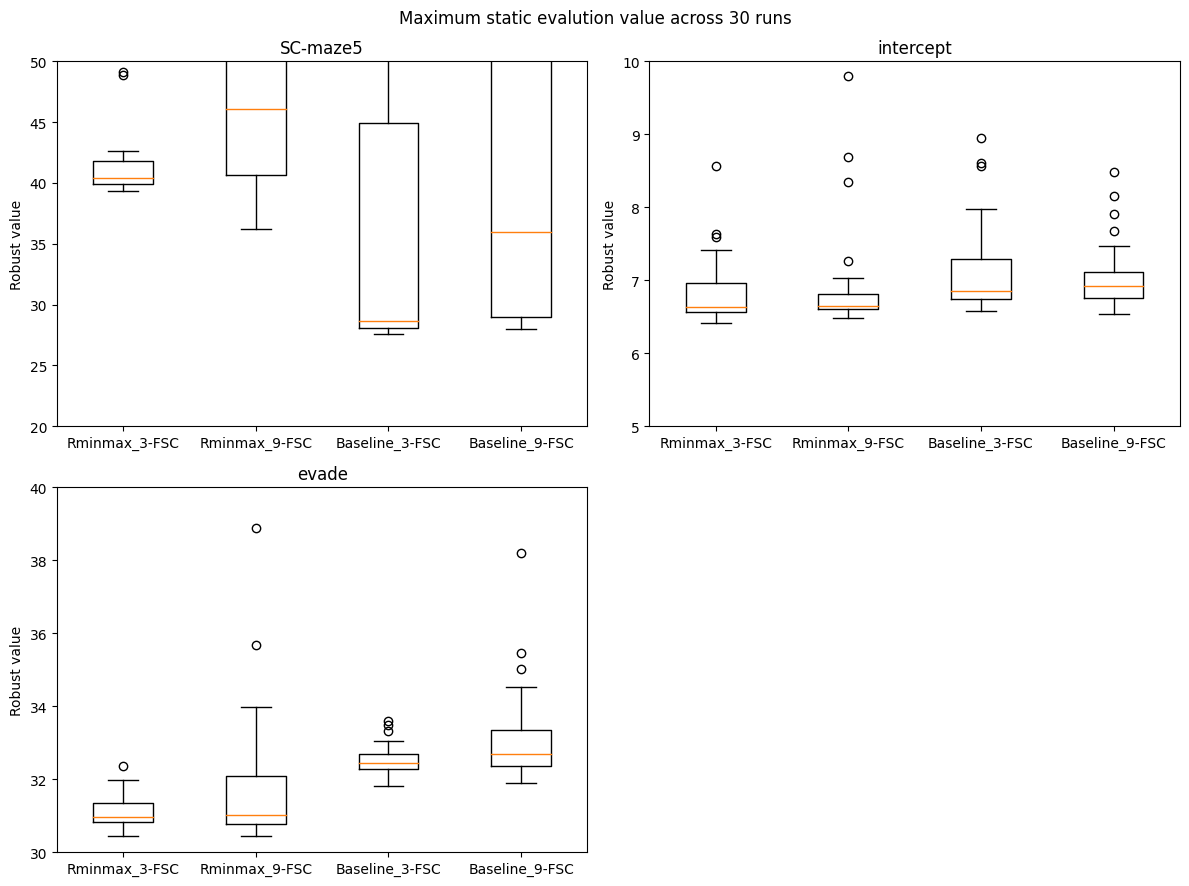

In [11]:
plt.figure(figsize=(12,9))
for i, benchmark in enumerate(benchmarks[:3]):
    plt.subplot(2, 2, i+1)
    lists = []
    for method in ['Rminmax', 'Rminmax-BASELINE']:    
        # values = []
        for k in [3, 9]:
            results = get_traces(get_experiment_directory_str("./data/output/AAAI-RUN-14-08-2023_16h", k, benchmark, method), 'static_values')
            # lists.append(results[:, -10:].mean(axis=-1))
            # lists.append(results[:, -1])
            lists.append(results.max(axis=-1)[:, -10:].mean(axis=-1))
    plt.title(benchmark)
    plt.ylabel("Robust value")
    plt.boxplot(lists, labels=[f'Rminmax_3-FSC', f'Rminmax_9-FSC', f'Baseline_3-FSC', f'Baseline_9-FSC'])
    plt.ylim(ylim[benchmark])
    # if np.array(lists).max() > 1e3:
        # plt.yscale("log")
plt.suptitle("Maximum static evalution value across 30 runs")
plt.tight_layout()
plt.show()

In [12]:

lists = {}

def get_last_ten_str(results, round=True):
    return f"${np.round(results[:, -10:].mean(axis=-1).mean(), 2) if round else results[:, -10:].mean(axis=-1).mean():.2f}\pm{np.round(results[:, -10:].mean(axis=-1).std(), 2) if round else results[:, -10:].mean(axis=-1).std():.2f}$"

def get_last_idx_str(results, round=True):
    return f"${np.round(results[:, -1].mean(), 2) if round else results[:, -1].mean():.2f}\pm{np.round(results[:, -1].std(), 2) if round else results[:, -1].var():.2f}$"

for method in ['Rminmax']:
    lists[method] = []
    for benchmark in benchmarks:
        values = []
        for k in [3, 9]:
            # results = get_traces(get_experiment_directory_str("./data/output/AAAI-RUN-14-08-2023_16h", k, benchmark, method), 'robust_value')
            # print(method, benchmark, k, 'robust_value', np.format_float_scientific(results[:, -1].mean(), 2) if scientific else results[:, -1].mean())
            # values.append(get_last_ten_str(results))
            # results = get_traces(get_experiment_directory_str("./data/output/AAAI-RUN-14-08-2023_16h", k, benchmark, method), 'static_values')
            # print(method, benchmark, k, 'static_values', np.format_float_scientific(np.max(results[..., -1], axis=0).mean(), 2) if scientific else np.max(results[..., -1], axis=0).mean())
            # print(method, benchmark, k, 'fsc_empirical_result', np.format_float_scientific(results[:, -1].mean(), 2) if scientific else results[:, -1].mean())
            results = get_traces(get_experiment_directory_str("./data/output/AAAI-RUN-14-08-2023_16h", k, benchmark, method), 'rnn_empirical_result')
            values.append(get_last_idx_str(results))
            # print(method, benchmark, k, 'rnn_empirical_result', np.format_float_scientific(results[:, -1].mean(), 2) if scientific else results[:, -1].mean())
            results = get_traces(get_experiment_directory_str("./data/output/AAAI-RUN-14-08-2023_16h", k, benchmark, method), 'fsc_empirical_result')
            values.append(get_last_idx_str(results))
        lists[method].append(values)

In [13]:
lists

{'Rminmax': [['$26.25\\pm1.44$',
   '$28.13\\pm5.06$',
   '$26.25\\pm1.44$',
   '$29.50\\pm6.08$'],
  ['$6.68\\pm0.43$', '$7.25\\pm1.37$', '$6.51\\pm0.55$', '$7.28\\pm1.37$'],
  ['$25.79\\pm3.36$', '$26.98\\pm3.38$', '$25.75\\pm3.19$', '$26.94\\pm4.61$'],
  ['$9.55\\pm0.78$', '$22.14\\pm3.62$', '$9.38\\pm0.74$', '$21.80\\pm3.24$']]}

In [14]:
sizes = ['$B_h=1$', '$B_h=2$']

In [15]:
idx = pd.MultiIndex(levels=[sizes, ['RNN', '3-FSC', 'RNN-', '9-FSC'], ['empir.']],
                codes=[[0, 0, 1, 1], [0, 1, 2, 3],[0, 0, 0, 0, ]],
                names=['Bottleneck dim.', 'Instance', 'Metric'])

In [16]:
idx

MultiIndex([('$B_h=1$',   'RNN', 'empir.'),
            ('$B_h=1$', '3-FSC', 'empir.'),
            ('$B_h=2$',  'RNN-', 'empir.'),
            ('$B_h=2$', '9-FSC', 'empir.')],
           names=['Bottleneck dim.', 'Instance', 'Metric'])

In [18]:
df = pd.DataFrame(lists['Rminmax'])
df.columns = idx
df.index = benchmarks
# df = df.applymap(lambda x: f"${x:.2f}$")
print(df.sort_index().style.to_latex())

\begin{tabular}{lllll}
Bottleneck dim. & \multicolumn{2}{r}{$B_h=1$} & \multicolumn{2}{r}{$B_h=2$} \\
Instance & RNN & 3-FSC & RNN- & 9-FSC \\
Metric & empir. & empir. & empir. & empir. \\
SC-maze5 & $26.25\pm1.44$ & $28.13\pm5.06$ & $26.25\pm1.44$ & $29.50\pm6.08$ \\
avoid & $9.55\pm0.78$ & $22.14\pm3.62$ & $9.38\pm0.74$ & $21.80\pm3.24$ \\
evade & $25.79\pm3.36$ & $26.98\pm3.38$ & $25.75\pm3.19$ & $26.94\pm4.61$ \\
intercept & $6.68\pm0.43$ & $7.25\pm1.37$ & $6.51\pm0.55$ & $7.28\pm1.37$ \\
\end{tabular}



In [ ]:
df = pd.DataFrame(lists['Rminmax-BASELINE'])
df.columns = idx
df.index = benchmarks[:3]
# df = df.applymap(lambda x: f"${x:.2f}$")
print(df.sort_index().style.to_latex())

\begin{tabular}{lllll}
Bottleneck dim. & \multicolumn{2}{r}{$B_h=1$} & \multicolumn{2}{r}{$B_h=2$} \\
Instance & RNN & 3-FSC & RNN- & 9-FSC \\
Metric & empir. & empir. & empir. & empir. \\
SC-maze5 & $15.94\pm0.95$ & $25.32\pm11.95$ & $15.94\pm0.95$ & $28.07\pm13.36$ \\
evade & $22.04\pm2.39$ & $22.62\pm2.85$ & $22.04\pm2.39$ & $23.63\pm4.15$ \\
intercept & $5.55\pm0.38$ & $5.92\pm1.17$ & $5.55\pm0.38$ & $6.08\pm1.20$ \\
\end{tabular}



In [ ]:
idx = pd.MultiIndex(levels=[sizes, ['Rminmax', 'Baseline'], ['RNN', '3-FSC', 'RNN-', '9-FSC']],
                codes=[[0, 0, 0, 0, 1, 1, 1, 1], [0, 0, 0, 0, 1, 1, 1, 1], [0, 1, 0, 1, 2, 3, 2, 3]],
                names=['Bottleneck dim.', 'Instance', 'Method'])

In [ ]:
np.concatenate((np.array(lists['Rminmax']), lists['Rminmax-BASELINE']), axis=-1)

array([['$26.25\\pm1.44$', '$28.13\\pm5.06$', '$26.25\\pm1.44$',
        '$29.50\\pm6.08$', '$15.94\\pm0.95$', '$25.32\\pm11.95$',
        '$15.94\\pm0.95$', '$28.07\\pm13.36$'],
       ['$6.68\\pm0.43$', '$7.25\\pm1.37$', '$6.51\\pm0.55$',
        '$7.28\\pm1.37$', '$5.55\\pm0.38$', '$5.92\\pm1.17$',
        '$5.55\\pm0.38$', '$6.08\\pm1.20$'],
       ['$25.79\\pm3.36$', '$26.98\\pm3.38$', '$25.75\\pm3.19$',
        '$26.94\\pm4.61$', '$22.04\\pm2.39$', '$22.62\\pm2.85$',
        '$22.04\\pm2.39$', '$23.63\\pm4.15$']], dtype='<U15')

In [ ]:
df = pd.DataFrame(np.concatenate((np.array(lists['Rminmax']), lists['Rminmax-BASELINE']), axis=-1))
df.columns = idx
df.index = benchmarks[:3]
# df = df.applymap(lambda x: f"${x:.2f}$")
print(df.sort_index().style.to_latex())

\begin{tabular}{lllllllll}
Bottleneck dim. & \multicolumn{4}{r}{$B_h=1$} & \multicolumn{4}{r}{$B_h=2$} \\
Instance & \multicolumn{4}{r}{Rminmax} & \multicolumn{4}{r}{Baseline} \\
Method & RNN & 3-FSC & RNN & 3-FSC & RNN- & 9-FSC & RNN- & 9-FSC \\
SC-maze5 & $26.25\pm1.44$ & $28.13\pm5.06$ & $26.25\pm1.44$ & $29.50\pm6.08$ & $15.94\pm0.95$ & $25.32\pm11.95$ & $15.94\pm0.95$ & $28.07\pm13.36$ \\
evade & $25.79\pm3.36$ & $26.98\pm3.38$ & $25.75\pm3.19$ & $26.94\pm4.61$ & $22.04\pm2.39$ & $22.62\pm2.85$ & $22.04\pm2.39$ & $23.63\pm4.15$ \\
intercept & $6.68\pm0.43$ & $7.25\pm1.37$ & $6.51\pm0.55$ & $7.28\pm1.37$ & $5.55\pm0.38$ & $5.92\pm1.17$ & $5.55\pm0.38$ & $6.08\pm1.20$ \\
\end{tabular}



In [24]:
losses_plot(AAAI, 3, 'avoid')

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (300,) + inhomogeneous part.